In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (LabelEncoder, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import (BaseEstimator, TransformerMixin)
import pickle

%matplotlib inline

## EDA

In [2]:
# Create feature and target dataframes
# The source dataset already had this split into two files
X = pd.read_csv('data/source_data/training_set_features.csv')
y = pd.read_csv('data/source_data/training_set_labels.csv')

The `training_set_labels.csv` file read to `y` contains two target variables, `h1n1_vaccine` and `seasonal_vaccine1`. For this project only the `h1n1_vaccine` target variable will be used.

In [3]:
# Sets target variable
y = y.h1n1_vaccine

Before any more analysis is done the dataset should be split into training and testsets to prevent data leakage.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

### Feature Analysis

In [5]:
# preview of feature dataframe
print(X_train.shape)
X_train.head()

(20030, 36)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
25194,25194,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,1.0,NaN,NaN
14006,14006,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,Married,NaN,Employed,lzgpxyit,"MSA, Not Principle City",2.0,1.0,fcxhlnwr,oijqvulv
11285,11285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,kbazzjca,"MSA, Principle City",0.0,1.0,wlfvacwt,hfxkjkmi
2900,2900,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Own,Employed,mlyzmhmf,"MSA, Not Principle City",0.0,0.0,mcubkhph,ukymxvdu
19083,19083,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,bhuqouqj,"MSA, Not Principle City",NaN,NaN,NaN,NaN


Our training dataset has 20030 entries and 36 features.

In [6]:
# preview at feature column information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 25194 to 23654
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                20030 non-null  int64  
 1   h1n1_concern                 19963 non-null  float64
 2   h1n1_knowledge               19943 non-null  float64
 3   behavioral_antiviral_meds    19974 non-null  float64
 4   behavioral_avoidance         19873 non-null  float64
 5   behavioral_face_mask         20016 non-null  float64
 6   behavioral_wash_hands        19994 non-null  float64
 7   behavioral_large_gatherings  19960 non-null  float64
 8   behavioral_outside_home      19972 non-null  float64
 9   behavioral_touch_face        19932 non-null  float64
 10  doctor_recc_h1n1             18395 non-null  float64
 11  doctor_recc_seasonal         18395 non-null  float64
 12  chronic_med_condition        19313 non-null  float64
 13  child_under_

Dataset contains features of multiple types, a lot of them appear to be categorical.

There also appears to be a lot of missing values in this dataframe. Let's check the amount for each feature.

In [7]:
# Checks amount of Nan values in feature dataframe
X_train.isna().sum()

respondent_id                      0
h1n1_concern                      67
h1n1_knowledge                    87
behavioral_antiviral_meds         56
behavioral_avoidance             157
behavioral_face_mask              14
behavioral_wash_hands             36
behavioral_large_gatherings       70
behavioral_outside_home           58
behavioral_touch_face             98
doctor_recc_h1n1                1635
doctor_recc_seasonal            1635
chronic_med_condition            717
child_under_6_months             605
health_worker                    597
health_insurance                9233
opinion_h1n1_vacc_effective      299
opinion_h1n1_risk                292
opinion_h1n1_sick_from_vacc      301
opinion_seas_vacc_effective      349
opinion_seas_risk                387
opinion_seas_sick_from_vacc      407
age_group                          0
education                       1040
race                               0
sex                                0
income_poverty                  3269
m

The majority of our features contain missing values that will need to be handled. Three features, (`health_insurance`, `employment_industry`, and `employment_occupation`), are missing values for about half of their entries and will most likely be dropped from the dataset. If our future models perform poorly filling these features in using a regression model, filling in by ratio of occurences in other entries, or finding a quick correlation between them and other features can be used to fill them in.

The feature `respondent_id` will also be dropped as it has no use in our model.

In [8]:
# Drops columns containing many missing entries
X_train_mod = X_train.drop(columns = ['respondent_id', 
                      'health_insurance', 
                      'employment_industry', 
                      'employment_occupation'], 
           axis=1).copy()

Next lets check which or our numerical type features are continuous or categorical using scatterplots. 

In [9]:
# Grabs numberical columns from training set
X_train_num = X_train_mod.select_dtypes(include=['int64', 'float64']).copy()

def scatter_plots(X, n_cols, y='index'):
    '''
    Creates scatter plots for each feature in X against y
    Handles missing values of type Nan 
    
    Inputs: X = dataframe to have features plotted
            y = dataseries to be plotted against,
                default=index
            ncols = number of columns for figure
    Output: [# of features//ncols, ncols] sized figure of scatterplots
    '''
#     Calculates number of rows in figure
    n_rows = (X.shape[1]//n_cols)+1
    
#     Creates figure
    fig, axes = plt.subplots(figsize = (n_cols*5, n_rows*5),
                                  ncols=n_cols,
                                  nrows=n_rows);
#     Plots individual scatter plots
    for i, col in enumerate(X.columns):
        if type(y) == str:
            ind = range(X[col].notna().sum())
            axes[i//n_cols, i%n_cols].scatter(ind, X[col].dropna());
            axes[i//n_cols, i%n_cols].set_title(f'{col} vs. {y}');
        else:
            temp_df = pd.concat([X[col], y], axis=1).dropna()
            axes[i//n_cols, i%n_cols].scatter(temp_df.iloc[:,1], temp_df.iloc[:,0]);
            axes[i//n_cols, i%n_cols].set_title(f'{col} vs. {y.name}');
                        

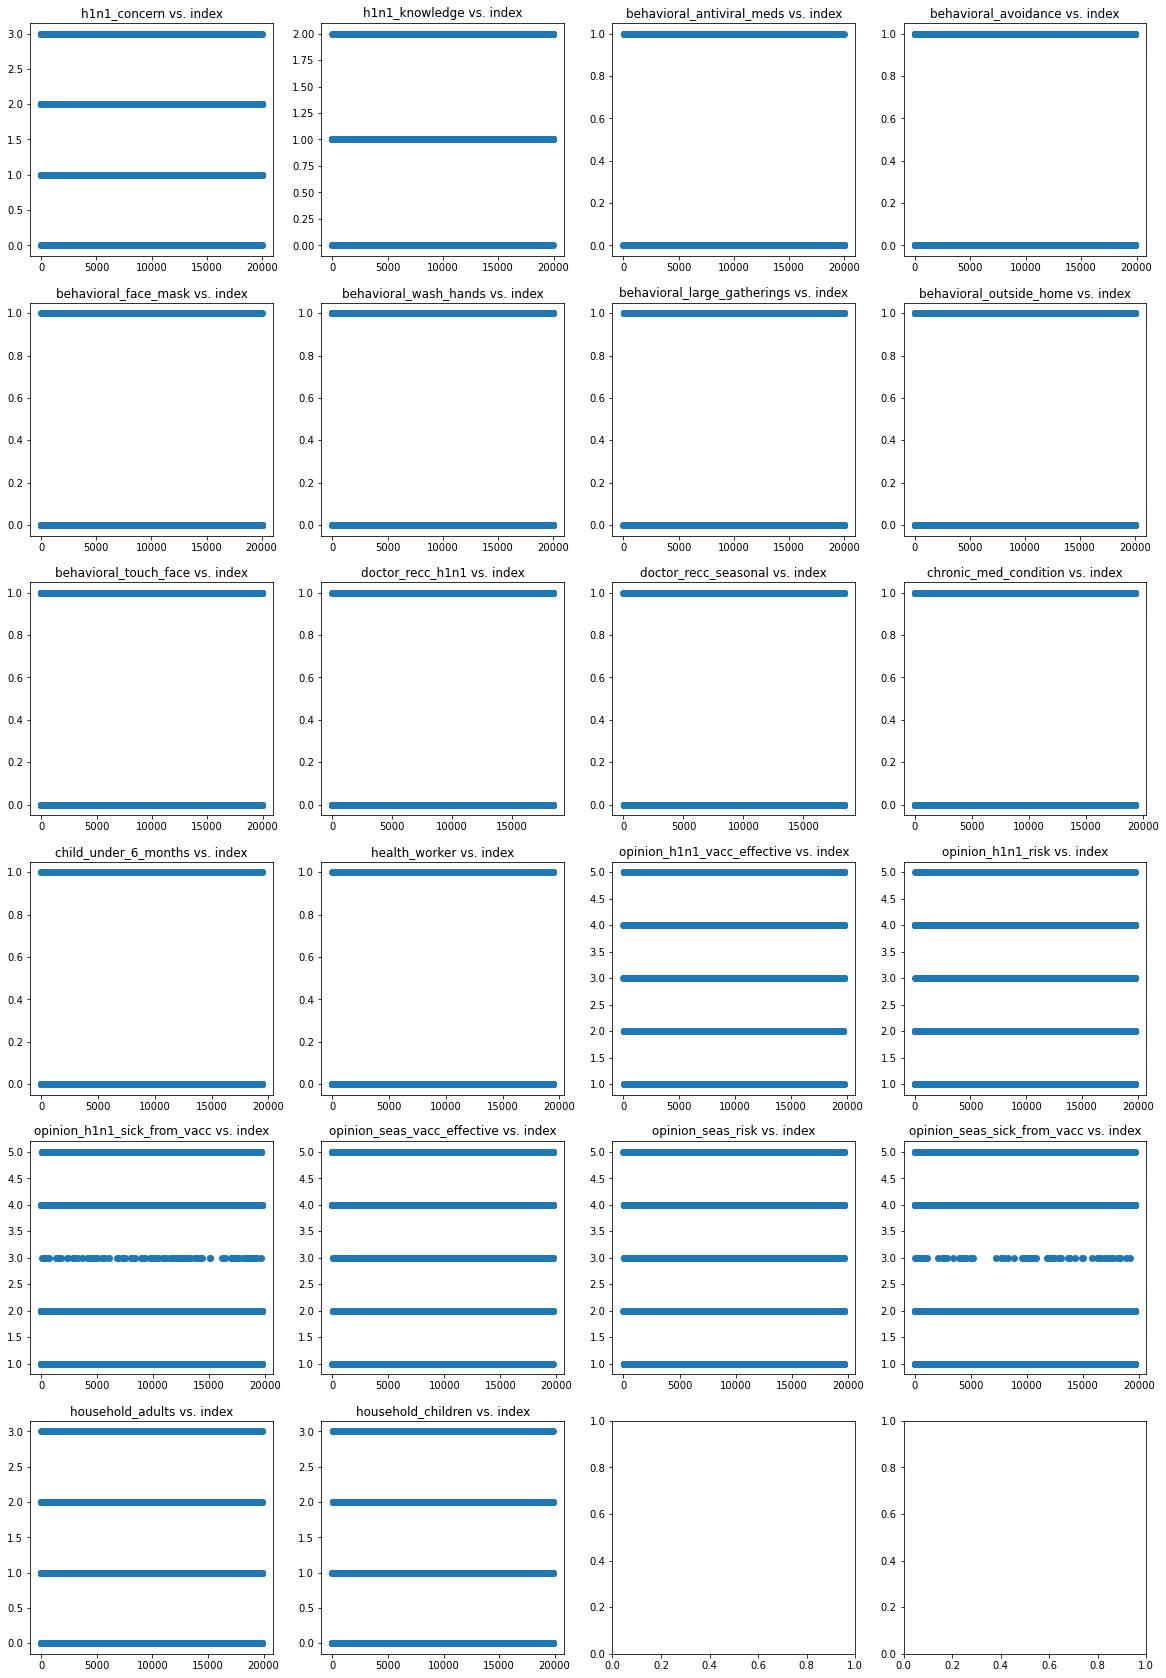

In [10]:
scatter_plots(X_train_num, 4)

It appears that all of our features can be considered categorical. Now lets try and determine how to handle the missing values. 

Though lets first determine if any of our rows are missing a lot of information.

In [11]:
# Creates a list with number of missing values in each row
nan_per_row = []
for i in range(len(X_train_mod)):
    nan_per_row.append(X_train_mod.iloc[i,:].isna().sum())

In [12]:
# creates dataseries of missing values
nan_per_row_ds = pd.Series(nan_per_row)

# gets frequeny of nan amounts in rows
nan_row_counts = nan_per_row_ds.value_counts()

In [13]:
# Prints the number of occurences in order from most nans in row to least
ordered_missing_nan = nan_row_counts[nan_row_counts.keys().sort_values(ascending=False)]
ordered_missing_nan

19        2
18       32
17       11
16      103
15       13
14       90
13       28
12       35
11       39
10       73
9        39
8       106
7        67
6        31
5       288
4       101
3       358
2      1694
1      2176
0     14744
dtype: int64

In [14]:
# Prints the cumulative sum starting with highest amount of nans to gain an idea of quantity
np.cumsum(ordered_missing_nan)

19        2
18       34
17       45
16      148
15      161
14      251
13      279
12      314
11      353
10      426
9       465
8       571
7       638
6       669
5       957
4      1058
3      1416
2      3110
1      5286
0     20030
dtype: int64

Our current features dataframe has 32 features after dropping those four columns. That means around 353 entries are missing about a third (11 values) of their features information. Since these entries are missing most of their information lets drop them from the dataset.

In [15]:
def drop_rows_by_nans(df, y, nan_threshold=None):
    '''
    Drop rows by quantity of nan values with nan_threshold as cut-off point
    
    Inputs: 
            df = DataFrame to be altered, should contain features and target concatenated together
            y = target variable column name
            nan_threshold = cut-off point to drop rows, default = None which results in a value
                            of half or a little larger than number of features
    
    Outputs: 
            feature_df = feature DataFrame
            y = Target Variable
    '''
    
#     Checks value of nan_threshold
    if nan_threshold == None:
#         Sets to half of or rounded up from half of feature columns
        nan_threshold = math.ceil((len(df.columns)-1)/2)
    
#     Finds nans contained in each row 
    nan_per_row = []
    for i in range(df.shape[0]):
        nan_per_row.append(X_train_mod.iloc[i,:].isna().sum())
    
#     Creates temporary column in df for number of nan values
    df['nans'] = nan_per_row
#     Creates dataframe of rows under nan threshold
    df = df[df.nans < nan_threshold]
#     Creates target variable
    y = df.h1n1_vaccine
#     returns tuple (feature_df, target)
    return (df.drop(['nans', 'h1n1_vaccine'], axis=1), y)

In [16]:
# Creates custom fuction transfromer
Many_Nans_Row_Drop_FT = FunctionTransformer(drop_rows_by_nans, kw_args = {'y': 'h1n1_vaccine',
                                                                          'nan_threshold': 11})

In [17]:
# Creates training set of both features and target to be transformed
train_set = pd.concat([X_train_mod, y_train], axis=1).copy()

In [18]:
# Transforms training set
X_train_mod, y_train = Many_Nans_Row_Drop_FT.fit_transform(train_set)

In [19]:
# Checks shape to see if worked correctly
X_train_mod.shape

(19677, 32)

In [20]:
# corr_dict = {}
# cols = X_mod.columns
# for i in range(X_mod.shape[1] - 1):
#     for j in range(i+1,X_mod.shape[1]):
#         key1 = cols[i] + '_+_' + cols[j]
#         corr_dict[key1] = {}
#         for k in range(X_mod.shape[0]):
#             col1_val = X_mod.iloc[k, i]
#             col2_val = X_mod.iloc[k, j]
            
#             key2 = str(col1_val) + '_+_' + str(col2_val)
#             corr_dict[key1][key2] = corr_dict[key1].get(key2, 0)+1

In [21]:
# corr_dict[list(corr_dict.keys())[0]]

1. Create a random implementation for missing values, in new columns
2. iteratively use classificatin models to predict values for missing entries

Need to convert objects to numbers.

In order to fill in the missing values, a logistic regression model will be used after randomly imputing existing variables but occurence rate for each feature.

The process for this is as follows.
1. Create copies of each column missing values in dataframe.
2. Randomly fill the missing values in these new columns with existing values by frequency.
3. 

In [22]:
# def feature_encoder(df):
#     '''
#     Takes in a dataframe and uses LabelEncoder on non-Nan values in each feature
    
#     Input: df = DataFrame
#     Output: dataframe with Nan values and encoded non-Nan values
#     '''
    
# #     Iterates through each feature and encodes non-Nan values
#     for feature in df.columns:
#         df.loc[df[feature].notnull(), feature] = LabelEncoder().fit_transform(df.loc[df[feature].notnull(), feature])
#     return df

In [23]:
# Creatures custom encoder function transformer
# Encoder_FT = FunctionTransformer(feature_encoder)

In [24]:
# # Grabs object feature column names to be encoded
# object_cols = list(X_mod.select_dtypes('object').columns)

# # Creates Column Transformer with custom encoder function transformer
# Encoder_CT = ColumnTransformer(transformers = [('encoder', Encoder_FT, object_cols)],
#                        remainder='passthrough')

In [25]:
# # Runs ColumnTransformer on feature dataset
# X_mod_encoded = Encoder_CT.fit_transform(X_mod)

In [26]:
# # Creates Dataframe using encoded dataset
# X_mod_encoded = pd.DataFrame(X_mod_encoded,
#                              index = X_mod.index,
#                              columns = X_mod.columns)
# X_mod_encoded.head()

In [27]:
# # Saves X_mod_encoded to pickle file for ease to reload
# with open('data/temp_pickle_files/X_mod_encoded.pickle', 'wb') as f:
#     pickle.dump(X_mod_encoded, f)

In [28]:
# Saves X_train_mod to pickle file for ease to reload
with open('data/temp_pickle_files/X_train_mod.pickle', 'wb') as f:
    pickle.dump(X_train_mod, f)

In [29]:
# Opens X_mod_encoded pickle file
# with open('data/temp_pickle_files/X_mod_encoded.pickle', 'rb') as f:
#     X_mod_encoded = pickle.load(f)

In [30]:
# Opens X_train_mod pickle file
with open('data/temp_pickle_files/X_train_mod.pickle', 'rb') as f:
    X_train_mod = pickle.load(f)

In [31]:
# def random_imputation(df, feature):
#     '''
#     Fills in missing feature data by randomly imputing existing values by
#     occurence rate
#     '''
    
#     number_missing = df[feature].isnull().sum()
#     observed_values = df.loc[df[feature].notnull(), feature]
#     df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
#     return df

Process was modified from an article written by Shashanka Subrahmanya in his article <a href="https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression">Missing Data Imputation using Regression</a>.

His process utilized linear regression and didn't create custom transfomers. For the purpose of this project I have modified it to fit my needs.

In [135]:
class RandomImputer(BaseEstimator, TransformerMixin):
    '''
    Randomly imputes values for missing data in new columns.
    Values are based off of existing values and rates of occurences.
    
    Initialized with optional parameter columns which mark which
    columns will be transformed, if left to default value 'all', all
    columns with missing values will be filled.
    '''
    
#     Initializes class object
    def __init__(self, missing_columns='all_missing_columns'):
        self.missing_columns = missing_columns

#     If columns equals all sets attribute to all missing columns 
    def fit(self, X, y=None):
        if self.missing_columns == 'all_missing_columns':
            nan_amount = X.isna().sum()
            self.missing_columns = list(nan_amount[nan_amount>0].index)
#     Handles if single column entered as string
        elif type(self.missing_columns) == str:
            self.missing_columns = [self.missing_columns]
        return self
    
    
    def transform(self, X, y=None):
        df = X.copy()
        for col in self.missing_columns:
#     Creates copy of column to have calues imputed into
            df[col+'_imp'] = df[col]
#     Finds number of missing values in column
            number_missing = df[col].isnull().sum()
#     Gets existing values from column, repeat values are kept to ensure proper ratio
            observed_values = df.loc[df[col].notnull(), col]
#     Randomly Imputes observed values replacing all missing information
            df.loc[df[col].isnull(), col+'_imp'] = np.random.choice(observed_values, number_missing, replace = True)

#     Creates column index variable to be called to set DataFrame index
        self.final_columns = df.columns
        
        return df
    
#     Returns final columns index
    def get_final_columns(self):
        return self.final_columns

In [136]:
# Creates class object
rand_imp = RandomImputer()

In [137]:
# Fits and transforms dataset
X_mod_imputed = rand_imp.fit_transform(X_train_mod)

In [138]:
# checks if all columns besides original columns with missing data are filled in
X_mod_imputed.drop(rand_imp.missing_columns, axis=1).isna().sum()

age_group                          0
race                               0
sex                                0
hhs_geo_region                     0
census_msa                         0
h1n1_concern_imp                   0
h1n1_knowledge_imp                 0
behavioral_antiviral_meds_imp      0
behavioral_avoidance_imp           0
behavioral_face_mask_imp           0
behavioral_wash_hands_imp          0
behavioral_large_gatherings_imp    0
behavioral_outside_home_imp        0
behavioral_touch_face_imp          0
doctor_recc_h1n1_imp               0
doctor_recc_seasonal_imp           0
chronic_med_condition_imp          0
child_under_6_months_imp           0
health_worker_imp                  0
opinion_h1n1_vacc_effective_imp    0
opinion_h1n1_risk_imp              0
opinion_h1n1_sick_from_vacc_imp    0
opinion_seas_vacc_effective_imp    0
opinion_seas_risk_imp              0
opinion_seas_sick_from_vacc_imp    0
education_imp                      0
income_poverty_imp                 0
m

Now that each feature has been filled with randomly imputed data, it's time to apply a regression models to predict the values for missing data from the other features data instead of randomly imputing the data.

This requires an iterative process for each column containing missing data. Since each column is categorical they will need to be OHE for each iteration and the target variable (column missing data) will need to be treated as a multiclass classification problem. Also since the features contain various amount of information, I would like to iterate through the columns filling by number of missing values. I am not sure if filling in the columns with little data missing first, or a lot of missing data is better. By filling in the columns with less missing data first, it could help achieve more accurate information to fill the columns with many missing entries. On the other hand filling in the columns with many missing values, will take out more randomness for future iterations, by filling in more random columns with predicted values from regression. To start I believe I will try the method of handling columns with many missing entries first. Also since many columns and iterations are needed Decision Trees will used to predict the missing values.

In [ ]:
class iterative_classification(BaseEstimator, TransformerMixin):
    def __init__(self):

In [ ]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = X_mod_encoded[feature + "_imp"]
    parameters = list(set(X_mod_encoded.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = LogisticRegression(random_state=42)
    model.fit(X = X_mod_encoded[parameters], y = X_mod_encoded[feature + '_imp'])
    
    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[X_mod_encoded[feature].isnull(), "Det" + feature] = model.predict(X_mod_encoded[parameters])[X_mod_encoded[feature].isnull()]

In [ ]:
X_mod.iloc[:,12:].describe()

In [ ]:
# Preview target dataframe
y.head()